# Deficient Encoding Evidence

The big idea of the deficient encoding hypothesis as an account of the spacing effect is that:
1. Familiarity impairs attention and memory
2. Repeated experience of an item increases familiarity with that item
3. On the other hand, familiarity decreases with intervening study, allowing better memory of repetitions

The MINERVA-DE model (Collins et al, 2020) implements a model with these mechanisms to account for various effects in recognition memory. In the model, a short-term memory store called primary memory is maintained with a long-term secondary memory. When a word is attended, its familiarity is computed relative to the items in primary memory. The more familiar a studied item is to existing items in primary memory, the less well it is encoded in secondary memory. This process is called discrepancy encoding, because encoding is strongest for items that are discrepant with information already stored in primary memory.

We are interested in realizing a similar mechanism within the framework of retrieved context theory. We'll do it through modification of the context maintenance and retrieval model (CMR). CMR has no primary memory representation exactly like the one outlined for MINERVA-DE above, but a similar component in CMR is its representation of temporal context, reflecting "a recency-weighted average of information related to recently presented stimuli". 

> When an item is encoded, contextual information associated with the item is retrieved and integrated into the context representation. Studied items become associated to the context that was active when they were presented, so that context can serve as a cue to retrieve items, and recalled items can retrieve the context that is associated with them. When an item is recalled, its feature representation is reactivated, which allows the system to reinstate the context representation associated with the item. This reinstated context can then be used to cue for another item on the list.

CMR's context representation is different from MINERVA-DE's primary memory representation in some key ways. For example, while MINERVA-DE's model directly track item features encoded in recent experience, item features can only be retrieved indirectly using CMR's context representation by treating it as a memory cue. However, it's intuitive to suppose that familiarity with an item depends to some extent on this current state of context. If items and contextual states are associated in memory, then reinstating a contextual state (something hypothesized to happen whenever an item is encoded or retrieved) should correspond with increased familiarity with its associated items. 

As for how familiarity might then modulate memory, within CMR, a learning rate scalar modulates how strongly items are encoded into memory. The deficient encoding hypothesis calls for a mechanism to be added to CMR that modulates the value of this scalar based on the familarity of the currently encoded item. A hypothetical CMR-DE would thus track for each encoding index a measure of each item's familiarity based on the current state of context. The learning rate for memories of the current item and its contextual associations would then vary inversely with its familiarity.

Our approach to testing the deficient encoding hypothesis about repetition effects should thus turn on the implications of familiarity hinging on the contextual dynamics that organize memory according to CMR. Here, the main implication we focus on is the corollary hypothesis that familiarity-based memory impairment for a given item can be increased without necesarily repeating experience of that item. Instead, contextual states associated with the item from a previous presentation can be reinstated through repetition of items originally presented near said previous presentations that share many of item's contextual associations. 

Consider a study list $A, B, ..., B, A$, with an indeterminate number of items intervening between $AB$ and $BA$. Encoding $A$ integrates $A$'s pre-existing contextual associations into context and builds an enduring two-way association between the current state of context and $A$. When $B$ is next encoded and this same process is carried out, $B$ becomes associated with a contextual state that contains information about $A$. Later, repeated experience of $B$ retrieves and reinstates that learned contextual state associated with $A$. Consequently, familiarity with $A$ is increased right before it is presented a second time, impairing memory of that second presentation. Later on, the probability of recalling $A$ is depressed relative to if $B$ were presented under different conditions, such as:
- For its initial presentation, before or many more positions after initial presentation of $A$
- For its second presentation, many more positions before or after second presentation of $A$

Let's try to develop a model-free way to measure this hypothesized effect.

## Dataset

In this notebook, we search for evidence of this pattern in the Lohnas (2014) dataset, particularly conditions 3 and 4:

3. pure spaced lists consisting of items presented twice at lags 1-8, where lag is defined as the number of intervening items between a repeated item's presentations; 
4. mixed lists consisting of once presented, massed and spaced items. Within each session, subjects encountered three lists of each of these four types. 

In each list there were 40 presentation positions, such that in the control lists each position was occupied by a unique list item, and in the pure massed and pure spaced lists, 20 unique words were presented twice to occupy the 40 positions. In the mixed lists 28 once-presented and six twice-presented words occupied the 40 positions. In the pure spaced lists, spacings of repeated items were chosen so that each of the lags 1-8 occurred with equal probability. In the mixed lists, massed repetitions (lag=0) and spaced repetitions (lags 1-8) were chosen such that each of the 9 lags of 0-8 were used exactly twice within each session. The order of presentation for the different list types was randomized within each session. 

## Approach

As an initial pass, we'll try to identify all trials in the dataset with $A, B, ..., B, A$ subsequences, with no multiple presentations of a single item between $AB$ and $BA$. We'll also require at least one intervening item between presentations of $B$, ideally more. 

For comparison, we'll also look for trials where there are no multiply-presented items between spaced $A$ presentations, and for trials where where there is just one.

To help brainstorm controls, we'll plot for each detected subsequence the lag between $A$ presentations against the serial position of $A$ in a dot plot.

Across conditions, our main result may include:
1. Recall rates for $A$ under the target subsequence vs under other orderings
2. Correlation between recall rate for A and lag between $B_1$ and $A_1$.
3. Correlation between recall rate for A and lag between $B_2$ and $A_2$. 

In [ ]:
import numpy as np
import pandas as pd
from repfr.datasets import prepare_repdata

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_repdata(
    '../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Trial Identification

In [ ]:
result = []

for trial_index, sequence in enumerate(presentations):
    
    if list_types[trial_index] < 3:
        continue
    
    for item in np.unique(sequence):
        list_positions = np.where(sequence == item)[0]

        # no use considering items presented just once
        if (len(list_positions) == 1):
            continue
        
        # also don't consider sequences with lag below a minimum
        lag = list_positions[1] - list_positions[0] - 1
        subsequence = sequence[list_positions[0]+1:list_positions[1]]
        if lag < 3:
            continue
            
        # track and avoid sequences where # unique items < lag - 1
        multiply_presented_items = lag - len(
            np.unique(subsequence))
        if multiply_presented_items > 1:
            continue
            
        # if item at i+1 and j-1 are the same, that's target group
        if subsequence[0] == subsequence[-1]:
            group = 0
            
        # if zero multiply presented items in subsequence, another group
        elif multiply_presented_items == 0:
            group = 1
        else:
            group = 2
        
        if group == 1:
            lagB, lagB1, lagB2 = -1, -1, -1
        else:
            # find positions of multiply repeated item within subsequence
            for candidate in subsequence:
                sub_positions = np.where(subsequence == candidate)[0]
                if len(sub_positions) != 1:
                    lagB = sub_positions[1] - sub_positions[0] - 1
                    lagB1 = sub_positions[0]
                    lagB2 = len(subsequence) - sub_positions[1]
                    break
        
        result.append(
            [trial_index, list_types[trial_index], subjects[trial_index], group, item, 
             item+1 in trials[trial_index], list_positions[0], 
             lag, lagB, lagB1, lagB2])
        
result = pd.DataFrame(
    result, columns=['trial', 'list_type', 'subject', 'group', 'item', 'recalled', 'startPos', 
                     'lagA', 'lagB', 'lagB1', 'lagB2'])
result.head()

,trial,list_type,subject,group,item,recalled,startPos,lagA,lagB,lagB1,lagB2
0,0,4,1,2,9,True,9,8,0,1,6
1,0,4,1,1,19,True,21,4,-1,-1,-1
2,0,4,1,1,21,False,24,5,-1,-1,-1
3,0,4,1,1,23,False,27,5,-1,-1,-1
4,2,3,1,2,1,True,1,6,1,2,2


In [ ]:
#result = result[result.group==2]
#result = result[result.list_type==3]

#result.lagB1.corr(result.recalled)

In [ ]:
#result.lagB2.corr(result.recalled)

## Initial Analyses

### Initial Comparison of Recall Probabilities

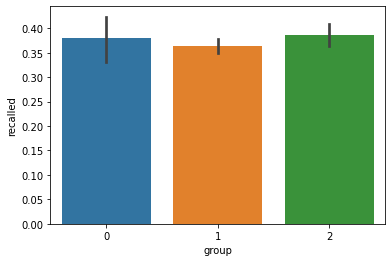

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.barplot(data=result, x="group", y="recalled", estimator=np.mean)

### Lag Distributions by Group

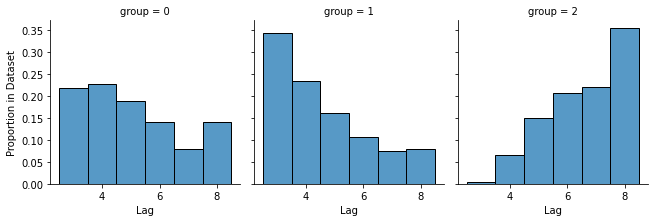

In [ ]:
g = sns.FacetGrid(result, col="group")
g.map_dataframe(sns.histplot, x="lagA", discrete=True, stat="probability")
g.set_axis_labels("Lag", "Proportion in Dataset")
plt.show()

### Serial Position by Group

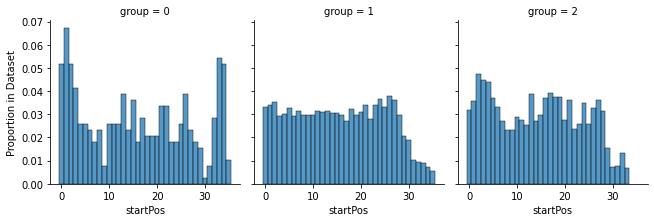

In [ ]:
g = sns.FacetGrid(result, col="group")
g.map_dataframe(sns.histplot, x="startPos", discrete=True, stat='probability')
g.set_axis_labels("startPos", "Proportion in Dataset")
plt.show()

### Subject ID by Group

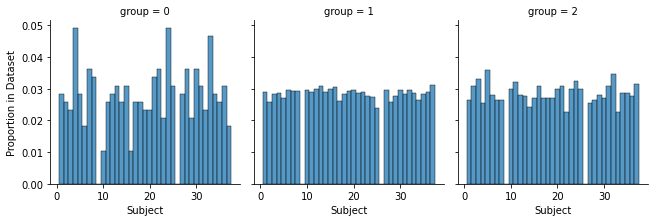

In [ ]:
g = sns.FacetGrid(result, col="group")
g.map_dataframe(sns.histplot, x="subject", discrete=True, stat='probability')
g.set_axis_labels("Subject", "Proportion in Dataset")
plt.show()

## Adding Stronger Controls
We'll try to find for every relevant subsequence in the target group a matching subsequence in the other group(s) that has the same list_type, startPos, subject, lagA. But not trial. And obviously recall is the variable we're interested in.

### Matching Features
We define a new function that finds matching subsequences this way.

In [ ]:
def match_features(target_group, list_type, startPos, subject, lagA):
    
    result = []
    for trial_index, sequence in enumerate(presentations):
    
        # test for matching list_type
        if list_types[trial_index] != list_type:
            continue
            
        # test for matching subject
        if subjects[trial_index] != subject:
            continue

        for item in np.unique(sequence):
            list_positions = np.where(sequence == item)[0]

            # no use considering items presented just once
            if (len(list_positions) == 1):
                continue

            # test for matching startPos
            if list_positions[0] != startPos:
                continue

            # test for matching lag
            lag = list_positions[1] - list_positions[0] - 1
            subsequence = sequence[list_positions[0]+1:list_positions[1]]
            if lag != lagA:
                continue
                
            # track and avoid sequences where # unique items < lag - 1
            multiply_presented_items = lag - len(
                np.unique(subsequence))
            if multiply_presented_items > 1:
                continue
            
            # if item at i+1 and j-1 are the same, that's target group
            if subsequence[0] == subsequence[-1]:
                group = 0
                
             # if zero multiply presented items in subsequence, another group
            elif multiply_presented_items == 0:
                group = 1
            else:
                group = 2
                
            if group != target_group:
                continue
                
            if group == 1:
                lagB, lagB1, lagB2 = -1, -1, -1
            else:
                # find positions of multiply repeated item within subsequence
                for candidate in subsequence:
                    sub_positions = np.where(subsequence == candidate)[0]
                    if len(sub_positions) != 1:
                        lagB = sub_positions[1] - sub_positions[0] - 1
                        lagB1 = sub_positions[0]
                        lagB2 = len(subsequence) - sub_positions[1]
                        break
            
            result.append(
                [trial_index, list_types[trial_index], subjects[trial_index], group, item, 
                 item+1 in trials[trial_index], list_positions[0], 
                 lag, lagB, lagB1, lagB2])
    
    return result

### Building a DataFrame
For every subsequence in group 0 that we can find matching subsequences for in other groups (should we care if it's in all other groups? Figure that out later), we'll sample from the retrieved subsequences 100 times to build a dataframe with our controls.

In [ ]:
import random

result = []

for trial_index, sequence in enumerate(presentations):
    
    if list_types[trial_index] != 3:
        continue
    
    for item in np.unique(sequence):
        list_positions = np.where(sequence == item)[0]

        # no use considering items presented just once
        if (len(list_positions) == 1):
            continue
        
        # also don't consider sequences with lag below a minimum
        lag = list_positions[1] - list_positions[0] - 1
        subsequence = sequence[list_positions[0]+1:list_positions[1]]
        if lag < 3:
            continue
            
        # track and avoid sequences where # unique items < lag - 1
        multiply_presented_items = lag - len(
            np.unique(subsequence))
        if multiply_presented_items > 1:
            continue
            
        # if item at i+1 and j-1 are the same, that's target group
        if subsequence[0] != subsequence[-1]:
            continue
        
        # we'll never include this group in analyses of B lags
        lagB, lagB1, lagB2 = -1, -1, -1
        
        # look for matched trials in each group to include in dataframe
        matched_trials1 = match_features(
            1, 3, list_positions[0], subjects[trial_index], lag)
        matched_trials2 = match_features(
            2, 3, list_positions[0], subjects[trial_index], lag)
        
        # if we can't find matched trials, go next
        if len(matched_trials1) == 0 or len(matched_trials2) == 0:
            continue
        for i in range(100):
            result.append(
                [trial_index, list_types[trial_index], subjects[trial_index], 
                 0, item, item+1 in trials[trial_index], list_positions[0], 
                 lag, lagB, lagB1, lagB2])
            
        # build a balanced sample from matched groups for comparison
        if len(matched_trials1) == 0:
            pass
        elif len(matched_trials1) == 1:
            for i in range(100):
                result.append(matched_trials1[0])
        else:
            for i in range(100):
                result.append(random.choice(matched_trials1))
                
        if len(matched_trials2) == 0:
            pass
        elif len(matched_trials2) == 1:
            for i in range(100):
                result.append(matched_trials2[0])
        else:
            for i in range(100):
                result.append(random.choice(matched_trials2))
        
result = pd.DataFrame(
    result, columns=['trial', 'list_type', 'subject', 'group', 'item', 'recalled', 'startPos', 
                     'lagA', 'lagB', 'lagB1', 'lagB2'])
result.head()

,trial,list_type,subject,group,item,recalled,startPos,lagA,lagB,lagB1,lagB2
0,19,3,1,0,2,True,2,4,-1,-1,-1
1,19,3,1,0,2,True,2,4,-1,-1,-1
2,19,3,1,0,2,True,2,4,-1,-1,-1
3,19,3,1,0,2,True,2,4,-1,-1,-1
4,19,3,1,0,2,True,2,4,-1,-1,-1


### Comparison of Recall Probabilities

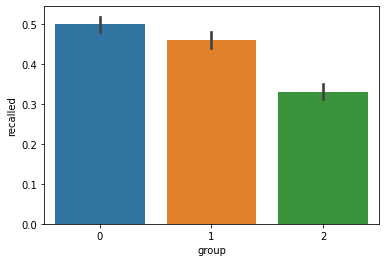

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.barplot(data=result, x="group", y="recalled", estimator=np.mean)

### Lag Distributions by Group

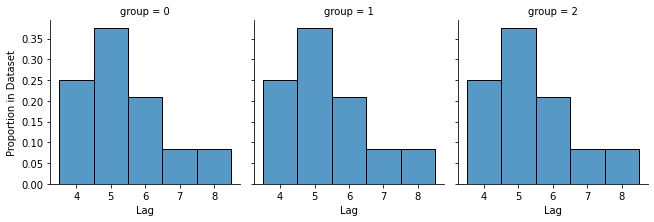

In [ ]:
g = sns.FacetGrid(result, col="group")
g.map_dataframe(sns.histplot, x="lagA", discrete=True, stat="probability")
g.set_axis_labels("Lag", "Proportion in Dataset")
plt.show()

### Serial Position by Group

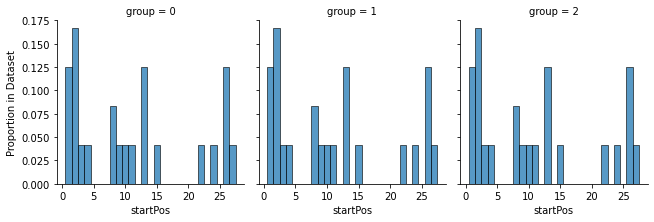

In [ ]:
g = sns.FacetGrid(result, col="group")
g.map_dataframe(sns.histplot, x="startPos", discrete=True, stat='probability')
g.set_axis_labels("startPos", "Proportion in Dataset")
plt.show()

### Subject ID by Group

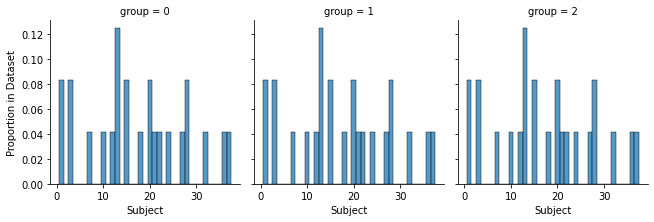

In [ ]:
g = sns.FacetGrid(result, col="group")
g.map_dataframe(sns.histplot, x="subject", discrete=True, stat='probability')
g.set_axis_labels("Subject", "Proportion in Dataset")
plt.show()

### Focusing On Where lagB1 == 0

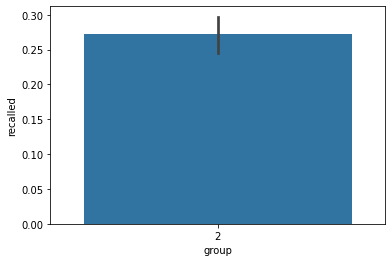

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.barplot(data=result[result.lagB1 == 0], x="group", y="recalled", estimator=np.mean)

In [ ]:
first_test = result[result.lagB1 == 0]
first_test.lagB2.corr(first_test.recalled)

-0.24315019730446846

When B1 occurs right after A1, the larger the gap between repetition of B and repetition of A, the lower the recall rate. This is the opposite of what would be predicted

In [ ]:
second_test = result[result.lagB2 == 1]
second_test.lagB1.corr(second_test.recalled)

0.5005244825383245

We have to control for lag between A presentations. Let's start a fresh notebook.